# Sentiment Analysis - Star Wars Original Trilogy

We use the **labMT (Language Assessment by Mechanical Turk)** dataset which provides happiness scores for ~10,000 words on a scale of 1-9.

## Approach
1. **Data Extraction**: Load HTML scripts, extract and clean dialogue data, save to JSON
2. **Basic Sentiment Analysis**: Simple average of word happiness scores (primary method)
3. **TF-IDF Weighted Sentiment**: Weight sentiment by term importance to capture character-specific language patterns (exploratory - tested but showed no significant improvement over basic approach)

## Notebook Structure
This notebook follows a clean flow:
- **HTML Data Extraction**: Load raw HTML scripts, extract scenes and dialogues, clean and save to JSON
- **Data Loading**: Load pre-processed character and location dialogues from JSON files
- **Basic Analysis**: Start with fundamental sentiment analysis using the labMT lexicon
- **TF-IDF Analysis**: Advanced weighting approach (tested but found to have limited benefit)

In [1]:
import os
import io
import json
import re
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from wordcloud import WordCloud
from pathlib import Path

DATA_DIR = Path("../data")
FIGURES_DIR = Path("../figures")

FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Minimum word counts for analysis validity
MIN_WORDS_PRIMARY = 0
MIN_WORDS_SECONDARY = 0

# Sentiment thresholds (labMT neutral is ~5.0)
NEUTRAL = 5.3
SENTIMENT_DELTA = 1.0  # Words with |happiness - 5| > 1.0 are "sentiment-bearing"

# Load stopwords from NLTK
from nltk.corpus import stopwords
import nltk

try:
    STOP_WORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOP_WORDS = set(stopwords.words('english'))

print(f"Loaded {len(STOP_WORDS)} stopwords from NLTK")

Loaded 198 stopwords from NLTK


In [2]:
# Load character dialogues
char_dialogues_path = DATA_DIR / "character_dialogues_merged.json"
print(f"Loading character dialogues from: {char_dialogues_path}")
with open(char_dialogues_path, "r", encoding="utf-8") as f:
    character_dialogues = json.load(f)

print(f"✓ Loaded dialogues for {len(character_dialogues)} characters")

Loading character dialogues from: ../data/character_dialogues_merged.json
✓ Loaded dialogues for 137 characters


In [3]:
# Load location dialogues  
location_dialogues_path = DATA_DIR / "location_dialogues_merged.json"
print(f"\nLoading location dialogues from: {location_dialogues_path}")
with open(location_dialogues_path, "r", encoding="utf-8") as f:
    location_dialogues = json.load(f)

print(f"✓ Loaded dialogues for {len(location_dialogues)} locations")


Loading location dialogues from: ../data/location_dialogues_merged.json
✓ Loaded dialogues for 456 locations


In [4]:
def tokenize(text: str) -> list:
    return re.findall(r"[a-z']+", text.lower())

def get_word_stem_variants(word: str) -> list:
    """
    Handles: -s, -es, -ed, -ing, -ly, -er, -est, -ness, -ment, -tion, -'s (possessive)
    """
    variants = [word]  # Always try original first
    
    if len(word) < 3:
        return variants
    
    # Handle possessive 's: Luke's -> Luke, character's -> character
    if word.endswith("'s") and len(word) > 3:
        variants.append(word[:-2])  # Remove 's
    
    # -ing: walking -> walk, running -> run (double consonant), hoping -> hope
    if word.endswith('ing') and len(word) > 4:
        base = word[:-3]
        variants.append(base)                    # walking -> walk
        variants.append(base + 'e')              # hoping -> hope
        if len(base) >= 2 and base[-1] == base[-2]:  # running -> run
            variants.append(base[:-1])
    
    # -ed: walked -> walk, hoped -> hope, stopped -> stop
    if word.endswith('ed') and len(word) > 3:
        base = word[:-2]
        variants.append(base)                    # walked -> walk
        variants.append(base + 'e')              # hoped -> hope (if ended in 'e')
        if word.endswith('ied'):                 # tried -> try
            variants.append(word[:-3] + 'y')
        if len(base) >= 2 and base[-1] == base[-2]:  # stopped -> stop
            variants.append(base[:-1])
    
    # -s: cats -> cat, boxes -> box, tries -> try
    if word.endswith('s') and len(word) > 2:
        variants.append(word[:-1])               # cats -> cat
        if word.endswith('es') and len(word) > 3:
            variants.append(word[:-2])           # boxes -> box
            if word.endswith('ies'):             # tries -> try
                variants.append(word[:-3] + 'y')
            if word.endswith('ves'):             # lives -> life
                variants.append(word[:-3] + 'f')
                variants.append(word[:-3] + 'fe')
    
    # -ly: quickly -> quick
    if word.endswith('ly') and len(word) > 3:
        variants.append(word[:-2])
        if word.endswith('ily'):                 # happily -> happy
            variants.append(word[:-3] + 'y')
    
    # -er: faster -> fast, bigger -> big, nicer -> nice
    if word.endswith('er') and len(word) > 3:
        base = word[:-2]
        variants.append(base)                    # faster -> fast
        variants.append(base + 'e')              # nicer -> nice
        if len(base) >= 2 and base[-1] == base[-2]:  # bigger -> big
            variants.append(base[:-1])
    
    # -est: fastest -> fast, biggest -> big, nicest -> nice
    if word.endswith('est') and len(word) > 4:
        base = word[:-3]
        variants.append(base)                    # fastest -> fast
        variants.append(base + 'e')              # nicest -> nice
        if len(base) >= 2 and base[-1] == base[-2]:  # biggest -> big
            variants.append(base[:-1])
    
    # -ness: happiness -> happy, sadness -> sad
    if word.endswith('ness') and len(word) > 5:
        base = word[:-4]
        variants.append(base)                    # sadness -> sad
        if word.endswith('iness'):               # happiness -> happy
            variants.append(word[:-5] + 'y')
    
    # -ment: movement -> move
    if word.endswith('ment') and len(word) > 5:
        variants.append(word[:-4])
        variants.append(word[:-4] + 'e')
    
    # -tion/-sion: creation -> create
    if (word.endswith('tion') or word.endswith('sion')) and len(word) > 5:
        base = word[:-4]
        variants.append(base)
        variants.append(base + 'e')
        variants.append(base + 'te')             # creation -> create
    
    # Remove duplicates while preserving order
    seen = set()
    unique_variants = []
    for v in variants:
        if v not in seen and len(v) >= 2:
            seen.add(v)
            unique_variants.append(v)
    
    return unique_variants


def lookup_sentiment(word: str, lexicon: dict) -> tuple:
    # Try each variant
    for variant in get_word_stem_variants(word):
        if variant in lexicon:
            return lexicon[variant], variant
    return None, None


def get_sentiment_bearing_words(lexicon: dict, delta: float = SENTIMENT_DELTA) -> set:
    return {
        word for word, score in lexicon.items()
        if abs(score - NEUTRAL) > delta
    }

## 1. Load Sentiment Dataset (labMT)

The labMT dataset provides human-rated happiness scores for approximately 10,000 English words.
- **Scale**: 1 (most negative) to 9 (most positive)
- **Neutral**: ~5.0 (words like "the", "is", "and")
- **Source**: Mechanical Turk workers rating word happiness


In [5]:
local_sentiment_data = "../../data/Data_Set_S1.txt"
raw_sentiment_url = "https://raw.githubusercontent.com/rifolio/dtu-projects-2025-autumn/master/social-graphs/data/Data_Set_S1.txt"

if os.path.exists(local_sentiment_data):
    print(f"Loading sentiment data from local file: {local_sentiment_data}")
    sentiment_df = pd.read_csv(local_sentiment_data, sep="\t", skiprows=2, header=0)
else:
    print(f"Downloading sentiment data from: {raw_sentiment_url}")
    r = requests.get(raw_sentiment_url, timeout=30)
    r.raise_for_status()
    with io.StringIO(r.text) as fh:
        sentiment_df = pd.read_csv(fh, sep="\t", skiprows=2, header=0)

# clean up data types
sentiment_df["word"] = sentiment_df["word"].astype("string")
for col in ["twitter_rank", "google_rank", "nyt_rank", "lyrics_rank"]:
    sentiment_df[col] = sentiment_df[col].replace("--", np.nan)
    sentiment_df[col] = pd.to_numeric(sentiment_df[col], errors="coerce").astype("Int64")

# word -> happiness score mapping
word_to_happiness = dict(zip(sentiment_df["word"], sentiment_df["happiness_average"]))

Loading sentiment data from local file: ../../data/Data_Set_S1.txt


In [6]:
print(f"\nSentiment Dataset Statistics:")
print(f"  Total words: {len(word_to_happiness):,}")
print(f"  Score range: {min(word_to_happiness.values()):.2f} - {max(word_to_happiness.values()):.2f}")
print(f"  Mean score: {np.mean(list(word_to_happiness.values())):.4f}")
print(f"  Median score: {np.median(list(word_to_happiness.values())):.4f}")


Sentiment Dataset Statistics:
  Total words: 10,222
  Score range: 1.30 - 8.50
  Mean score: 5.3752
  Median score: 5.4400


## 2. Vocabulary Coverage Analysis

Before computing sentiment, let's analyze how well the labMT lexicon covers Star Wars dialogue vocabulary. 

**Key question**: Are sci-fi specific words (lightsaber, droid, hyperspace, Jedi, etc.) missing from the sentiment lexicon, potentially compressing our sentiment range?


In [7]:
def analyze_vocabulary_coverage(dialogues: dict, lexicon: dict, use_stemming: bool = True) -> dict:
    # Collect all words from dialogues using consistent tokenizer
    all_words = []
    for char, lines in dialogues.items():
        for line in lines:
            tokens = tokenize(line)  # Use consistent tokenizer!
            all_words.extend(tokens)
    
    word_counts = Counter(all_words)
    total_tokens = len(all_words)
    unique_words = len(word_counts)
    
    # Separate covered vs missing words (with optional stemming)
    covered_words = {}
    missing_words = {}
    stem_matches = {}  # Track which stems were matched
    
    for word, count in word_counts.items():
        if use_stemming:
            score, matched = lookup_sentiment(word, lexicon)
            if score is not None:
                covered_words[word] = count
                if matched != word:  # Track stem matches
                    stem_matches[word] = matched
            else:
                missing_words[word] = count
        else:
            if word in lexicon:
                covered_words[word] = count
            else:
                missing_words[word] = count
    
    covered_tokens = sum(covered_words.values())
    missing_tokens = sum(missing_words.values())
    
    return {
        'total_tokens': total_tokens,
        'unique_words': unique_words,
        'covered_unique': len(covered_words),
        'missing_unique': len(missing_words),
        'covered_tokens': covered_tokens,
        'missing_tokens': missing_tokens,
        'coverage_unique_pct': len(covered_words) / unique_words * 100,
        'coverage_tokens_pct': covered_tokens / total_tokens * 100,
        'covered_words': covered_words,
        'missing_words': missing_words,
        'word_counts': word_counts,
        'stem_matches': stem_matches  # Words matched via stemming
    }

# Analyze vocabulary coverage
coverage = analyze_vocabulary_coverage(character_dialogues, word_to_happiness)

# Also compute word counts using consistent tokenizer
word_counts = {}
for char, lines in character_dialogues.items():
    total = sum(len(tokenize(line)) for line in lines)
    word_counts[char] = total

In [8]:
print("VOCABULARY COVERAGE ANALYSIS (WITH STEMMING)")
print(f"\nTotal word tokens in dialogue: {coverage['total_tokens']:,}")
print(f"Unique words in dialogue: {coverage['unique_words']:,}")
print(f"\nCoverage by unique words: {coverage['covered_unique']:,} / {coverage['unique_words']:,} = {coverage['coverage_unique_pct']:.1f}%")
print(f"Coverage by token count: {coverage['covered_tokens']:,} / {coverage['total_tokens']:,} = {coverage['coverage_tokens_pct']:.1f}%")
print(f"\nMissing unique words: {coverage['missing_unique']:,} ({100 - coverage['coverage_unique_pct']:.1f}%)")
print(f"Missing token occurrences: {coverage['missing_tokens']:,} ({100 - coverage['coverage_tokens_pct']:.1f}%)")

# Show stemming matches
stem_matches = coverage.get('stem_matches', {})
if stem_matches:
    print(f"\n🔗 Words matched via STEMMING: {len(stem_matches)}")
    stem_tokens = sum(coverage['covered_words'].get(w, 0) for w in stem_matches)
    print(f"   Token occurrences from stemming: {stem_tokens:,}")
    
    # Show examples of stem matches
    stem_examples = sorted(stem_matches.items(), 
                          key=lambda x: coverage['covered_words'].get(x[0], 0), 
                          reverse=True)[:30]
    print(f"\n   Top stem matches (word -> matched base):")
    for word, base in stem_examples:
        count = coverage['covered_words'].get(word, 0)
        score = word_to_happiness.get(base, 0)
        print(f"   '{word}' -> '{base}' ({count} occurrences, sentiment={score:.2f})")

# Compare with non-stemmed coverage
coverage_no_stem = analyze_vocabulary_coverage(character_dialogues, word_to_happiness, use_stemming=False)
print(f"\n📊 Comparison (with vs without stemming):")
print(f"   Without stemming: {coverage_no_stem['coverage_tokens_pct']:.1f}% token coverage")
print(f"   With stemming: {coverage['coverage_tokens_pct']:.1f}% token coverage")
print(f"   Improvement: +{coverage['coverage_tokens_pct'] - coverage_no_stem['coverage_tokens_pct']:.1f}% tokens")


VOCABULARY COVERAGE ANALYSIS (WITH STEMMING)

Total word tokens in dialogue: 32,778
Unique words in dialogue: 4,037

Coverage by unique words: 2,957 / 4,037 = 73.2%
Coverage by token count: 29,708 / 32,778 = 90.6%

Missing unique words: 1,080 (26.8%)
Missing token occurrences: 3,070 (9.4%)

🔗 Words matched via STEMMING: 432
   Token occurrences from stemming: 834

   Top stem matches (word -> matched base):
   'beeps' -> 'beep' (33 occurrences, sentiment=5.32)
   'fighters' -> 'fighter' (25 occurrences, sentiment=4.58)
   'barks' -> 'bark' (20 occurrences, sentiment=4.59)
   'laser' -> 'las' (19 occurrences, sentiment=5.06)
   'whistles' -> 'whistle' (18 occurrences, sentiment=6.31)
   'beeping' -> 'beep' (10 occurrences, sentiment=5.32)
   'speeder' -> 'speed' (10 occurrences, sentiment=6.24)
   'robots' -> 'robot' (9 occurrences, sentiment=6.12)
   'destroyer' -> 'destroy' (9 occurrences, sentiment=2.52)
   'highness' -> 'high' (8 occurrences, sentiment=6.64)
   'disappears' -> 'disa

In [9]:
# Character names to exclude from missing words analysis
CHARACTER_NAMES = set([
    # Main characters
    'LUKE', 'HAN', 'LEIA', 'VADER', 'THREEPIO', 'ARTOO', 'BEN', 'YODA', 'LANDO',
    'EMPEROR', 'CHEWBACCA', 'CHEWIE', 'OBIWAN', 'OBI-WAN', 'OBI', 'WAN', 'KENOBI', 'TARKIN', 'JABBA',
    'BIGGS', 'WEDGE', 'ACKBAR', 'PIETT', 'RIEEKAN', 'DODONNA', 'WILLARD',
    # Secondary characters
    'OWEN', 'BERU', 'GREEDO', 'MOTTI', 'TAGGE', 'TROOPER', 'OFFICER', 'COMMANDER',
    'PILOT', 'VOICE', 'CREATURE', 'GUARD', 'DROID', 'REBEL', 'IMPERIAL',
    'STORMTROOPER', 'SOLDIER', 'CAPTAIN', 'GENERAL', 'ADMIRAL', 'CONTROLLER',
    'WINGMAN', 'LEADER', 'PORKINS', 'GOLD', 'RED', 'GRAY', 'ROGUE', 'ECHO',
    'DECK', 'BASE', 'INTERCOM', 'ANNOUNCER', 'THREEPIO\'S', 'ARTOO\'S',
    'FETT', 'BOBA', 'BIB', 'FORTUNA', 'BOUSHH', 'WICKET', 'LOGRAY', 'PAPLOO',
    'TEEBO', 'NIEN', 'NUNB', 'MADINE', 'MOTHMA', 'MON', 'JERJERROD', 'VEERS',
    'NEEDA', 'OZZEL', 'DACK', 'ZEV', 'HOBBIE', 'JANSON', 'DERLIN',
    # R2-D2 variants
    'R2-D2', 'R2D2', 'C-3PO', 'C3PO', 'ARTOO-DETOO', 'SEE-THREEPIO',
    # Generic headers
    'INT', 'EXT', 'CONTINUED', 'CUT', 'FADE', 'DISSOLVE', 'WIPE',
])

print("TOP 5 MOST COMMON MISSING WORDS")
print("(These words appear frequently but have NO sentiment score)")
print("(Character names excluded)\n")

# Filter out character names from missing words
missing_words_filtered = {
    word: count 
    for word, count in coverage['missing_words'].items()
    if word.upper() not in CHARACTER_NAMES
}

# Sort by count
missing_sorted = sorted(missing_words_filtered.items(), key=lambda x: x[1], reverse=True)
top_n = 50

# Show top 5
for i, (word, count) in enumerate(missing_sorted[:top_n], 1):
    print(f"{i}. '{word}': {count} occurrences")

# Calculate what % of missing tokens come from top 5 words (excluding character names)
top_missing_tokens = sum(c for w, c in missing_sorted[:top_n])
total_missing_filtered = sum(missing_words_filtered.values())
if total_missing_filtered > 0:
    print(f"\nTop {top_n} missing words (excluding character names) account for {top_missing_tokens:,} tokens ({top_missing_tokens/total_missing_filtered*100:.1f}% of filtered missing words)")

TOP 5 MOST COMMON MISSING WORDS
(These words appear frequently but have NO sentiment score)
(Character names excluded)

1. 'jedi': 39 occurrences
2. 'falcon': 31 occurrences
3. 'skywalker': 25 occurrences
4. 'wookiee': 24 occurrences
5. 'luke's': 23 occurrences
6. 'droids': 23 occurrences
7. 'ewoks': 19 occurrences
8. 'stormtroopers': 18 occurrences
9. 'alderaan': 18 occurrences
10. 'cockpit': 16 occurrences
11. 'huttese': 16 occurrences
12. 'lightsaber': 13 occurrences
13. 'subtitled': 12 occurrences
14. 'growls': 12 occurrences
15. 'comlink': 11 occurrences
16. 'asteroid': 11 occurrences
17. 'ewok': 11 occurrences
18. 'millennium': 10 occurrences
19. 'bolt': 9 occurrences
20. 'hyperdrive': 9 occurrences
21. 'deflector': 9 occurrences
22. 'bounty': 9 occurrences
23. 'calrissian': 9 occurrences
24. 'sandpeople': 9 occurrences
25. 'galaxy': 9 occurrences
26. 'darth': 8 occurrences
27. 'operational': 8 occurrences
28. 'troopers': 7 occurrences
29. 'deactivate': 7 occurrences
30. 'tractor

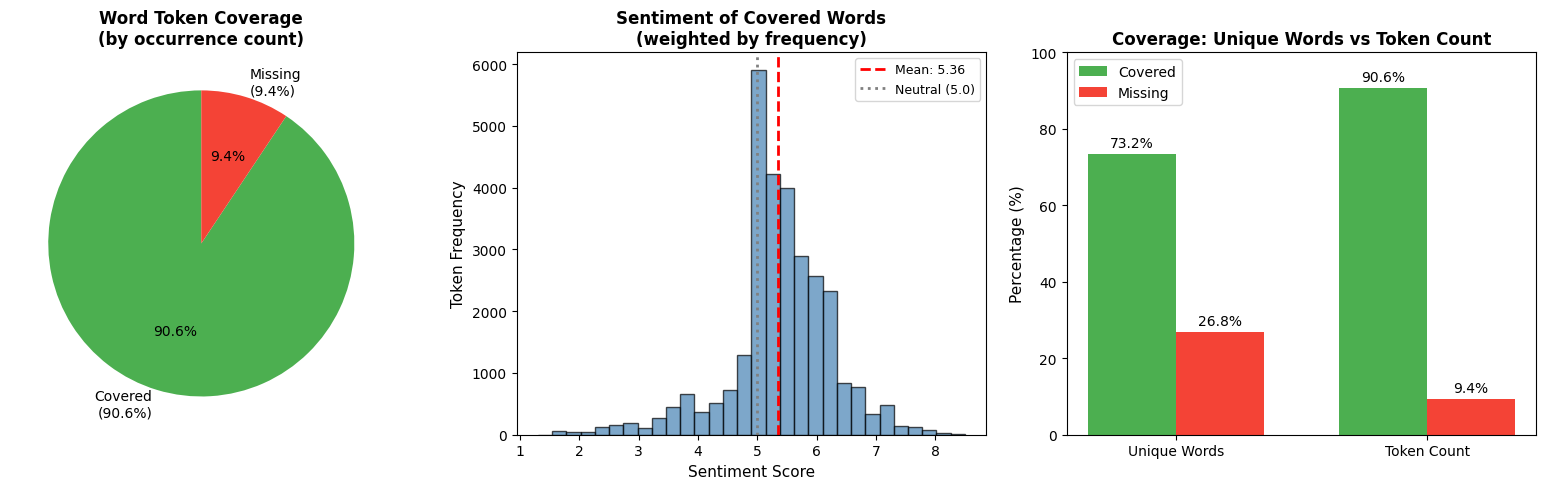


📈 Covered words sentiment statistics:
   Mean: 5.3553
   Std Dev: 0.8819
   Min: 1.30, Max: 8.50


In [10]:
# Visualize coverage and analyze sentiment distribution of covered words
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Coverage pie chart
ax = axes[0]
coverage_data = [coverage['covered_tokens'], coverage['missing_tokens']]
labels = [f"Covered\n({coverage['coverage_tokens_pct']:.1f}%)", 
          f"Missing\n({100-coverage['coverage_tokens_pct']:.1f}%)"]
colors = ['#4CAF50', '#f44336']
ax.pie(coverage_data, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax.set_title('Word Token Coverage\n(by occurrence count)', fontsize=12, fontweight='bold')

# 2. Sentiment distribution of COVERED words (weighted by frequency)
ax = axes[1]
covered_sentiments = []
for word, count in coverage['covered_words'].items():
    # Use stemming-aware lookup
    sentiment, _ = lookup_sentiment(word, word_to_happiness)
    if sentiment:
        covered_sentiments.extend([sentiment] * count)

ax.hist(covered_sentiments, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(np.mean(covered_sentiments), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {np.mean(covered_sentiments):.2f}')
ax.axvline(5.0, color='gray', linestyle=':', linewidth=2, label='Neutral (5.0)')
ax.set_xlabel('Sentiment Score', fontsize=11)
ax.set_ylabel('Token Frequency', fontsize=11)
ax.set_title('Sentiment of Covered Words\n(weighted by frequency)', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)

# 3. Compare unique vs token coverage
ax = axes[2]
categories = ['Unique Words', 'Token Count']
covered = [coverage['coverage_unique_pct'], coverage['coverage_tokens_pct']]
missing = [100 - coverage['coverage_unique_pct'], 100 - coverage['coverage_tokens_pct']]

x = np.arange(len(categories))
width = 0.35

bars1 = ax.bar(x - width/2, covered, width, label='Covered', color='#4CAF50')
bars2 = ax.bar(x + width/2, missing, width, label='Missing', color='#f44336')

ax.set_ylabel('Percentage (%)', fontsize=11)
ax.set_title('Coverage: Unique Words vs Token Count', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.set_ylim(0, 100)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "vocabulary_coverage.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print(f"\n📈 Covered words sentiment statistics:")
print(f"   Mean: {np.mean(covered_sentiments):.4f}")
print(f"   Std Dev: {np.std(covered_sentiments):.4f}")
print(f"   Min: {min(covered_sentiments):.2f}, Max: {max(covered_sentiments):.2f}")


## 3. Location Sentiment Analysis (Primary Focus)

Location sentiment is crucial for understanding the emotional atmosphere of different scenes and settings in the Star Wars trilogy.

We compute sentiment for each location using:
- All dialogue and action descriptions at that location
- The labMT "lens" approach: only sentiment-bearing words (|happiness - 5| > 1.0)
- Stopword removal to focus on meaningful content


In [11]:
def sentiment_score(text: str, 
                    use_lens: bool = True,
                    exclude_stopwords: bool = True,
                    use_stemming: bool = True) -> tuple[float | None, int]:
    """
    Compute sentiment score using consistent tokenization and optional stemming.
    
    Args:
        text: Input text string
        use_lens: If True, only use sentiment-bearing words (|h-5| > SENTIMENT_DELTA)
        exclude_stopwords: If True, exclude stopwords that skew results
        use_stemming: If True, try stem variants when word not found directly
        
    Returns:
        Tuple of (sentiment score or None, count of scored words)
    """
    tokens = tokenize(text)
    
    scores = []
    for token in tokens:
        if exclude_stopwords and token in STOP_WORDS:
            continue
        
        # Look up sentiment with optional stemming
        if use_stemming:
            score, matched = lookup_sentiment(token, word_to_happiness)
        else:
            score = word_to_happiness.get(token)
        
        if score is not None:
            if use_lens:
                if abs(score - NEUTRAL) > SENTIMENT_DELTA:
                    scores.append(score)
            else:
                scores.append(score)
    
    if scores:
        return sum(scores) / len(scores), len(scores)
    return None, 0


def compute_sentiments(dialogues: dict, min_words: int = MIN_WORDS_SECONDARY) -> dict:
    """
    Compute sentiment scores for a collection of dialogues (locations or characters).
    Uses lens approach and excludes stopwords.
    """
    results = {}
    for name, lines in dialogues.items():
        full_text = " ".join(lines) if lines else ""
        wc = sum(len(tokenize(line)) for line in lines)
        score, scored_count = sentiment_score(full_text, use_lens=True, exclude_stopwords=True)
        
        # Quality label
        if wc >= MIN_WORDS_PRIMARY:
            quality = "high"
        elif wc >= MIN_WORDS_SECONDARY:
            quality = "medium"
        else:
            quality = "low"
            
        results[name] = {
            'sentiment': score,
            'word_count': wc,
            'scored_words': scored_count,
            'quality': quality
        }
    return results

In [12]:
# =============================================================================
# LOCATION SENTIMENT (PRIMARY FOCUS)
# =============================================================================
print("Computing LOCATION sentiment...")
location_sentiments = compute_sentiments(location_dialogues)

# Compute word counts for locations
location_word_counts = {loc: data['word_count'] for loc, data in location_sentiments.items()}

# Filter to locations with sufficient content
valid_locations = {
    k: v['sentiment'] for k, v in location_sentiments.items()
    if v['sentiment'] is not None and v['word_count'] >= MIN_WORDS_SECONDARY
}

print(f"\n{'='*70}")
print("LOCATION SENTIMENT ANALYSIS")
print(f"{'='*70}")
print(f"\nTotal locations: {len(location_sentiments)}")
print(f"Locations with >= {MIN_WORDS_SECONDARY} words: {len(valid_locations)}")

if valid_locations:
    loc_scores = list(valid_locations.values())
    print(f"\nLocation Sentiment Statistics:")
    print(f"  Min: {min(loc_scores):.4f}")
    print(f"  Max: {max(loc_scores):.4f}")
    print(f"  Mean: {np.mean(loc_scores):.4f}")
    print(f"  Std Dev: {np.std(loc_scores):.4f}")

# =============================================================================
# CHARACTER SENTIMENT (Secondary)
# =============================================================================
print("\n\nComputing CHARACTER sentiment...")
character_sentiments = compute_sentiments(character_dialogues)

# Compute word counts for characters
word_counts = {char: data['word_count'] for char, data in character_sentiments.items()}

# Also create char_sentiments_lens for compatibility
char_sentiments_lens = character_sentiments

valid_characters = {
    k: v['sentiment'] for k, v in character_sentiments.items()
    if v['sentiment'] is not None and v['word_count'] >= MIN_WORDS_PRIMARY
}

print(f"\n{'='*70}")
print("CHARACTER SENTIMENT ANALYSIS")
print(f"{'='*70}")
print(f"\nTotal characters: {len(character_sentiments)}")
print(f"Characters with >= {MIN_WORDS_PRIMARY} words: {len(valid_characters)}")

if valid_characters:
    char_scores = list(valid_characters.values())
    print(f"\nCharacter Sentiment Statistics:")
    print(f"  Min: {min(char_scores):.4f}")
    print(f"  Max: {max(char_scores):.4f}")
    print(f"  Mean: {np.mean(char_scores):.4f}")
    print(f"  Std Dev: {np.std(char_scores):.4f}")


Computing LOCATION sentiment...

LOCATION SENTIMENT ANALYSIS

Total locations: 456
Locations with >= 0 words: 442

Location Sentiment Statistics:
  Min: 2.4200
  Max: 7.8800
  Mean: 5.1160
  Std Dev: 0.8307


Computing CHARACTER sentiment...

CHARACTER SENTIMENT ANALYSIS

Total characters: 137
Characters with >= 0 words: 105

Character Sentiment Statistics:
  Min: 1.7400
  Max: 7.2200
  Mean: 5.3585
  Std Dev: 1.0011


In [13]:
# Show top and bottom locations by sentiment
sorted_locations = sorted(
    [(loc, data) for loc, data in location_sentiments.items() 
     if data['sentiment'] is not None and data['word_count'] >= MIN_WORDS_SECONDARY],
    key=lambda x: x[1]['sentiment'],
    reverse=True
)

print(f"{'='*80}")
print("LOCATION SENTIMENT RANKING")
print(f"{'='*80}")

# Helper to truncate location names
def truncate_loc(loc, max_len=50):
    return loc[:max_len] + "..." if len(loc) > max_len else loc

print(f"\n🌟 TOP 15 Most POSITIVE Locations:")
for loc, data in sorted_locations[:15]:
    print(f"  {data['sentiment']:.3f} | {truncate_loc(loc)} ({data['word_count']} words)")

print(f"\n⚡ TOP 15 Most NEGATIVE Locations:")
for loc, data in sorted_locations[-15:][::-1]:
    print(f"  {data['sentiment']:.3f} | {truncate_loc(loc)} ({data['word_count']} words)")


LOCATION SENTIMENT RANKING

🌟 TOP 15 Most POSITIVE Locations:
  7.880 | EXT. TATOOINE - DUNES (9 words)
  7.513 | 135  INT MILLENNIUM FALCON - COCKPIT (9 words)
  7.240 | INT. MILLENNIUM FALCON - SOLO'S GUNPORT - COCKPIT (13 words)
  7.185 | EXT. LANDING PLATFORM - DOOR OF MILLENNIUM FALCON. (8 words)
  7.010 | INT. IMPERIAL STAR DESTROYER - BRIDGE (21 words)
  6.895 | 13   EXT JABBA'S PALACE (32 words)
  6.860 | EXT. SPACE AROUND FOURTH MOON OF YAVIN (19 words)
  6.793 | INT. GOLD LEADER'S COCKPIT (17 words)
  6.768 | INT. SNOWSPEEDER - COCKPIT (67 words)
  6.700 | EXT. SPACE - REBEL CRUISER (30 words)
  6.700 | EXT. SPACECRAFT IN SPACE (26 words)
  6.700 | INT. MILLENNIUM FALCON - SOLO'S GUNPORT (26 words)
  6.680 | EXT. HOTH - SNOWDRIFT - DAWN (10 words)
  6.636 | EXT. HOTH - SNOWDRIFT - DAY (41 words)
  6.633 | INT. GOLD FIVE'S Y-WING - COCKPIT (38 words)

⚡ TOP 15 Most NEGATIVE Locations:
  2.420 | INT. RED LEADER'S FIGHTER - COCKPIT (6 words)
  2.640 | INT. MILLENNIUM FALCON - CO

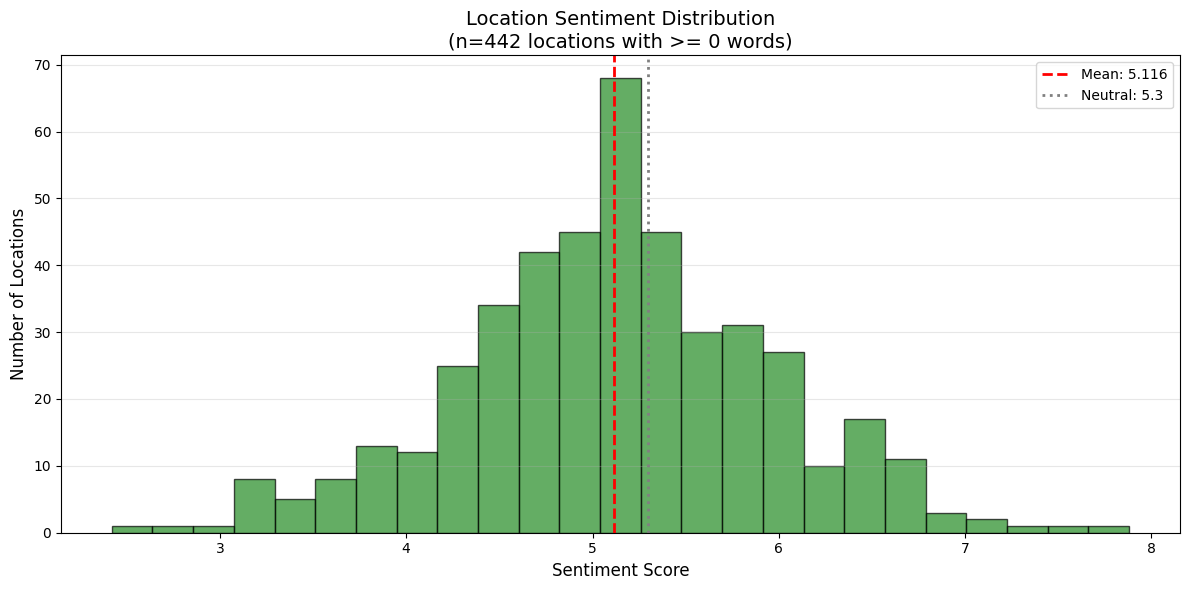


Location sentiment range: 2.420 to 7.880


In [14]:
# Visualize location sentiment distribution
fig, ax = plt.subplots(figsize=(12, 6))

loc_scores = [v['sentiment'] for v in location_sentiments.values() 
              if v['sentiment'] is not None and v['word_count'] >= MIN_WORDS_SECONDARY]

ax.hist(loc_scores, bins=25, color='forestgreen', edgecolor='black', alpha=0.7)
ax.axvline(np.mean(loc_scores), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(loc_scores):.3f}')
ax.axvline(NEUTRAL, color='gray', linestyle=':', linewidth=2, label=f'Neutral: {NEUTRAL}')

ax.set_xlabel('Sentiment Score', fontsize=12)
ax.set_ylabel('Number of Locations', fontsize=12)
ax.set_title(f'Location Sentiment Distribution\n(n={len(loc_scores)} locations with >= {MIN_WORDS_SECONDARY} words)', 
             fontsize=14)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "location_sentiment_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nLocation sentiment range: {min(loc_scores):.3f} to {max(loc_scores):.3f}")


## 4. Character Sentiment Analysis

Now we analyze sentiment at the character level. Note that character sentiment has more variance due to individual speaking styles.


In [15]:
# Show top and bottom characters by sentiment (using lens method)
# Use the primary threshold for main analysis
primary_chars = [
    (char, data) for char, data in char_sentiments_lens.items()
    if data['sentiment'] is not None and data['word_count'] >= MIN_WORDS_PRIMARY
]
primary_chars.sort(key=lambda x: x[1]['sentiment'], reverse=True)

print(f"{'='*70}")
print(f"CHARACTER SENTIMENT RANKING (>= {MIN_WORDS_PRIMARY} words, with lens)")
print(f"{'='*70}")

print(f"\n🌟 Top 10 Most POSITIVE Characters:")
for char, data in primary_chars[:10]:
    print(f"  {char}: {data['sentiment']:.4f} ({data['word_count']} words, {data['scored_words']} scored)")

print(f"\n⚡ Top 10 Most NEGATIVE Characters:")
for char, data in primary_chars[-10:][::-1]:
    print(f"  {char}: {data['sentiment']:.4f} ({data['word_count']} words, {data['scored_words']} scored)")

# Also show secondary tier
secondary_chars = [
    (char, data) for char, data in char_sentiments_lens.items()
    if data['sentiment'] is not None 
    and MIN_WORDS_SECONDARY <= data['word_count'] < MIN_WORDS_PRIMARY
]
secondary_chars.sort(key=lambda x: x[1]['sentiment'], reverse=True)

print(f"\n{'='*70}")
print(f"SECONDARY TIER ({MIN_WORDS_SECONDARY}-{MIN_WORDS_PRIMARY} words)")
print(f"{'='*70}")
if secondary_chars:
    print(f"\nMost positive: {secondary_chars[0][0]} ({secondary_chars[0][1]['sentiment']:.4f})")
    print(f"Most negative: {secondary_chars[-1][0]} ({secondary_chars[-1][1]['sentiment']:.4f})")
    print(f"Total in tier: {len(secondary_chars)} characters")


CHARACTER SENTIMENT RANKING (>= 0 words, with lens)

🌟 Top 10 Most POSITIVE Characters:
  STRANGE VOICE: 7.2200 (7 words, 1 scored)
  REBEL PILOT: 6.9700 (13 words, 2 scored)
  WINGMAN'S VOICE: 6.7400 (2 words, 1 scored)
  LIEUTENANT: 6.7400 (16 words, 1 scored)
  FIRST CONTROLLER: 6.7400 (2 words, 1 scored)
  OPERATOR: 6.7400 (2 words, 1 scored)
  SECOND COMMANDER: 6.7400 (2 words, 1 scored)
  ZEV: 6.6760 (62 words, 5 scored)
  MEDICAL DROID: 6.6400 (16 words, 1 scored)
  TRACKING OFFICER: 6.6400 (17 words, 2 scored)

⚡ Top 10 Most NEGATIVE Characters:
  BIB: 1.7400 (39 words, 1 scored)
  GANTRY OFFICER: 3.0900 (68 words, 2 scored)
  DEAK: 3.2200 (4 words, 1 scored)
  SENIOR CONTROLLER: 3.2900 (24 words, 2 scored)
  HEAD CONTROLLER: 3.4400 (6 words, 1 scored)
  NAVIGATOR: 3.6600 (2 words, 1 scored)
  RED LEADER'S VOICE: 3.7400 (21 words, 1 scored)
  WOMAN CONTROLLER: 3.8000 (5 words, 1 scored)
  VOICE: 3.8350 (40 words, 4 scored)
  NEEDA: 3.9327 (105 words, 11 scored)

SECONDARY TIER 

## 4. TF-IDF Weighted Sentiment Analysis

### Why TF-IDF?

The basic approach treats all words equally, but this has limitations:

1. **Common words dominate**: Words like "the", "is", "and" appear frequently but carry neutral sentiment (~5.0). They dilute the signal from more meaningful words.

2. **Character-specific vocabulary ignored**: A character who frequently says "hope" or "fear" should have that reflected more strongly.

3. **Corpus-wide patterns missed**: Words that are common across all characters (like "lightsaber", "ship") may not distinguish individual sentiment.

### TF-IDF Approach

**TF-IDF (Term Frequency - Inverse Document Frequency)** weights words by:
- **TF**: How often a word appears in a document (character's dialogue)
- **IDF**: How rare a word is across all documents (all characters)

$$\text{TF-IDF}(w, c) = \text{TF}(w, c) \times \log\left(\frac{N}{\text{DF}(w)}\right)$$

For sentiment, we weight each word's happiness score by its TF-IDF weight:

$$\text{Sentiment}_{\text{TF-IDF}}(c) = \frac{\sum_{w \in W_c} \text{TF-IDF}(w, c) \times h(w)}{\sum_{w \in W_c} \text{TF-IDF}(w, c)}$$

This gives more weight to:
- Words that are **distinctive** for a character (high TF)
- Words that are **rare** across the corpus (high IDF)


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

def compute_tfidf_weighted_sentiments(dialogues: dict, 
                                      wc_dict: dict = None,
                                      use_lens: bool = True,
                                      use_stopwords: bool = True,
                                      use_stemming: bool = True,
                                      min_df: int = 2,
                                      entity_type: str = "entity") -> dict:
    """
    Compute TF-IDF weighted sentiment scores for entities (characters or locations).
    
    Args:
        dialogues: Dict of {entity_name: [lines]} 
        wc_dict: Dict of {entity_name: word_count} - if None, computed internally
        use_lens: Only use sentiment-bearing words (|h-5| > SENTIMENT_DELTA)
        use_stopwords: Remove stopwords from TF-IDF
        use_stemming: Try stem variants when word not found
        min_df: Minimum document frequency for TF-IDF
        entity_type: "character" or "location" for logging
    
    Returns:
        Tuple of (results dict, vectorizer, tfidf_matrix, feature_names)
    """
    # Prepare documents (one per entity)
    entities = list(dialogues.keys())
    documents = [" ".join(lines) for lines in dialogues.values()]
    
    # Compute word counts if not provided
    if wc_dict is None:
        wc_dict = {e: sum(len(tokenize(line)) for line in lines) 
                   for e, lines in dialogues.items()}
    
    # Build stopword list for TF-IDF (same as our STOP_WORDS)
    stop_words = list(STOP_WORDS) if use_stopwords else None
    
    # Fit TF-IDF vectorizer with proper settings
    vectorizer = TfidfVectorizer(
        lowercase=True,
        token_pattern=r"[a-z']+",  # Match our tokenize() function - keeps apostrophes!
        min_df=min_df,  # Word must appear in at least N documents
        max_df=0.90,  # Exclude words in >90% of documents
        norm='l2',  # Proper normalization (not None!)
        stop_words=stop_words,  # Remove function words
    )
    
    tfidf_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()
    
    # Create word -> column index mapping
    word_to_idx = {word: idx for idx, word in enumerate(feature_names)}
    
    # Compute TF-IDF weighted sentiment for each entity
    results = {}
    
    for i, entity in enumerate(entities):
        # Get TF-IDF weights for this entity (normalized L2)
        tfidf_weights = tfidf_matrix[i].toarray().flatten()
        
        weighted_sum = 0.0
        weight_total = 0.0
        scored_words = 0
        
        for word, idx in word_to_idx.items():
            weight = tfidf_weights[idx]
            if weight > 0:
                # Look up sentiment with optional stemming
                if use_stemming:
                    score, matched = lookup_sentiment(word, word_to_happiness)
                else:
                    score = word_to_happiness.get(word)
                    matched = word if score else None
                    
                if score is not None:
                    # Only include if it's a sentiment-bearing word (when using lens)
                    is_sentiment_bearing = abs(score - NEUTRAL) > SENTIMENT_DELTA if use_lens else True
                    if is_sentiment_bearing:
                        weighted_sum += weight * score
                        weight_total += weight
                        scored_words += 1
        
        wc = wc_dict.get(entity, 0)
        
        # Data quality label
        if wc >= MIN_WORDS_PRIMARY:
            quality = "high"
        elif wc >= MIN_WORDS_SECONDARY:
            quality = "medium"
        else:
            quality = "low (insufficient content)"
        
        results[entity] = {
            'sentiment': weighted_sum / weight_total if weight_total > 0 else None,
            'word_count': wc,
            'scored_words': scored_words,
            'quality': quality
        }
    
    return results, vectorizer, tfidf_matrix, feature_names


# =============================================================================
# LOCATION TF-IDF SENTIMENT
# =============================================================================
print("=" * 70)
print("LOCATION TF-IDF SENTIMENT ANALYSIS")
print("=" * 70)

print("\nComputing LOCATION TF-IDF sentiment...")
location_tfidf_results, loc_vectorizer, loc_tfidf_matrix, loc_feature_names = compute_tfidf_weighted_sentiments(
    location_dialogues, 
    wc_dict=location_word_counts,
    use_lens=True, 
    use_stopwords=True,
    min_df=2,  # Word must appear in at least 2 locations
    entity_type="location"
)

# Filter to valid locations
valid_loc_tfidf = {
    k: v['sentiment'] for k, v in location_tfidf_results.items()
    if v['sentiment'] is not None and v['word_count'] >= MIN_WORDS_SECONDARY
}

print(f"\nLocations analyzed with TF-IDF: {len(valid_loc_tfidf)}")
if valid_loc_tfidf:
    loc_tfidf_scores = list(valid_loc_tfidf.values())
    print(f"  Min: {min(loc_tfidf_scores):.4f}, Max: {max(loc_tfidf_scores):.4f}")
    print(f"  Mean: {np.mean(loc_tfidf_scores):.4f}, Median: {np.median(loc_tfidf_scores):.4f}")
    print(f"  Std Dev: {np.std(loc_tfidf_scores):.4f}")
    
print(f"\nTF-IDF Vectorizer info (Locations):")
print(f"  Vocabulary size: {len(loc_feature_names)}")

# Compare Basic vs TF-IDF for locations
print(f"\n📊 Location Sentiment: Basic vs TF-IDF Comparison")
print("-" * 50)
loc_comparison = []
for loc in valid_locations:
    basic = location_sentiments.get(loc, {}).get('sentiment')
    tfidf = location_tfidf_results.get(loc, {}).get('sentiment')
    wc = location_word_counts.get(loc, 0)
    if basic and tfidf:
        loc_comparison.append({
            'location': loc,
            'basic': basic,
            'tfidf': tfidf,
            'diff': tfidf - basic,
            'word_count': wc
        })

# Sort by absolute difference
loc_comparison.sort(key=lambda x: abs(x['diff']), reverse=True)

print(f"\nLocations with LARGEST sentiment change (TF-IDF vs Basic):")
for item in loc_comparison[:10]:
    loc_short = item['location'][:45] + "..." if len(item['location']) > 45 else item['location']
    print(f"  {item['basic']:.3f} -> {item['tfidf']:.3f} ({item['diff']:+.3f}) | {loc_short}")


# =============================================================================
# CHARACTER TF-IDF SENTIMENT
# =============================================================================
print("\n" + "=" * 70)
print("CHARACTER TF-IDF SENTIMENT ANALYSIS")
print("=" * 70)

print("\nComputing CHARACTER TF-IDF sentiment...")
tfidf_results, vectorizer, tfidf_matrix, feature_names = compute_tfidf_weighted_sentiments(
    character_dialogues, 
    wc_dict=word_counts,
    use_lens=True, 
    use_stopwords=True,
    min_df=2,
    entity_type="character"
)

# Filter to high-quality characters for statistics
valid_tfidf = {
    k: v['sentiment'] for k, v in tfidf_results.items()
    if v['sentiment'] is not None and v['word_count'] >= MIN_WORDS_PRIMARY
}

print(f"\n{'='*60}")
print(f"TF-IDF SENTIMENT STATISTICS (>= {MIN_WORDS_PRIMARY} words)")
print(f"{'='*60}")
print(f"\nCharacters analyzed: {len(valid_tfidf)}")

if valid_tfidf:
    tfidf_scores = list(valid_tfidf.values())
    print(f"  Min: {min(tfidf_scores):.4f}, Max: {max(tfidf_scores):.4f}")
    print(f"  Mean: {np.mean(tfidf_scores):.4f}, Median: {np.median(tfidf_scores):.4f}")
    print(f"  Std Dev: {np.std(tfidf_scores):.4f}")
    
print(f"\nTF-IDF Vectorizer info:")
print(f"  Vocabulary size: {len(feature_names)}")
print(f"  Stopwords removed: {len(STOP_WORDS)}")


LOCATION TF-IDF SENTIMENT ANALYSIS

Computing LOCATION TF-IDF sentiment...

Locations analyzed with TF-IDF: 442
  Min: 2.4200, Max: 7.8800
  Mean: 5.0920, Median: 5.1135
  Std Dev: 0.8672

TF-IDF Vectorizer info (Locations):
  Vocabulary size: 3449

📊 Location Sentiment: Basic vs TF-IDF Comparison
--------------------------------------------------

Locations with LARGEST sentiment change (TF-IDF vs Basic):
  4.530 -> 3.495 (-1.035) | INT. MILLENNIUM FALCON - MAIN PASSAGEWAY
  4.450 -> 3.422 (-1.028) | INT. REBEL BASE - MAIN HANGER - MILLENNIUM FA...
  5.660 -> 4.849 (-0.811) | EXT. SPACE - MILLENNIUM FALCON - TIE FIGHTERS
  3.230 -> 2.420 (-0.810) | INT. DARTH VADER'S WINGMAN - COCKPIT
  4.652 -> 3.948 (-0.704) | EXT. MILLENNIUM FALCON - STAR DESTROYER, AVEN...
  4.380 -> 5.071 (+0.691) | EXT. SURFACE AROUND THE DEATH STAR
  4.730 -> 4.050 (-0.680) | 121  INT BUNKER - CONTROL ROOM
  4.394 -> 4.993 (+0.599) | EXT. TATOOINE - ROCK MESA - DUNE SEA - COASTL...
  4.189 -> 3.597 (-0.592) | I

In [17]:
# Show top and bottom characters by TF-IDF sentiment
primary_tfidf = [
    (char, data) for char, data in tfidf_results.items()
    if data['sentiment'] is not None and data['word_count'] >= MIN_WORDS_PRIMARY
]
primary_tfidf.sort(key=lambda x: x[1]['sentiment'], reverse=True)

print(f"{'='*70}")
print(f"TF-IDF CHARACTER SENTIMENT RANKING (>= {MIN_WORDS_PRIMARY} words)")
print(f"{'='*70}")

print(f"\n🌟 Top 10 Most POSITIVE Characters (TF-IDF):")
for char, data in primary_tfidf[:10]:
    # Compare with basic lens method
    basic = char_sentiments_lens.get(char, {}).get('sentiment', 0) or 0
    tfidf_score = data['sentiment']
    diff = tfidf_score - basic if basic else 0
    print(f"  {char}: {tfidf_score:.4f} (basic: {basic:.4f}, diff: {diff:+.4f})")

print(f"\n⚡ Top 10 Most NEGATIVE Characters (TF-IDF):")
for char, data in primary_tfidf[-10:][::-1]:
    basic = char_sentiments_lens.get(char, {}).get('sentiment', 0) or 0
    tfidf_score = data['sentiment']
    diff = tfidf_score - basic if basic else 0
    print(f"  {char}: {tfidf_score:.4f} (basic: {basic:.4f}, diff: {diff:+.4f})")


TF-IDF CHARACTER SENTIMENT RANKING (>= 0 words)

🌟 Top 10 Most POSITIVE Characters (TF-IDF):
  BOUSHH: 7.3158 (basic: 5.8050, diff: +1.5108)
  STRANGE VOICE: 7.2200 (basic: 7.2200, diff: +0.0000)
  REBEL PILOT: 7.0341 (basic: 6.9700, diff: +0.0641)
  MAN'S VOICE: 6.8560 (basic: 4.8350, diff: +2.0210)
  WINGMAN'S VOICE: 6.7400 (basic: 6.7400, diff: +0.0000)
  LIEUTENANT: 6.7400 (basic: 6.7400, diff: +0.0000)
  FIRST CONTROLLER: 6.7400 (basic: 6.7400, diff: +0.0000)
  OPERATOR: 6.7400 (basic: 6.7400, diff: +0.0000)
  SECOND COMMANDER: 6.7400 (basic: 6.7400, diff: +0.0000)
  SPEEDER LOT: 6.7298 (basic: 6.1900, diff: +0.5398)

⚡ Top 10 Most NEGATIVE Characters (TF-IDF):
  BIB: 1.7400 (basic: 1.7400, diff: +0.0000)
  GANTRY OFFICER: 3.1195 (basic: 3.0900, diff: +0.0295)
  DEAK: 3.2200 (basic: 3.2200, diff: +0.0000)
  SENIOR CONTROLLER: 3.2488 (basic: 3.2900, diff: -0.0412)
  GOLD TWO: 3.7000 (basic: 5.0467, diff: -1.3467)
  RED LEADER'S VOICE: 3.7400 (basic: 3.7400, diff: -0.0000)
  NEEDA: 

## 5. Comparison: Basic vs TF-IDF Sentiment

Let's compare how the two approaches differ and understand the implications.


In [18]:
# Compare basic (lens) vs TF-IDF for characters with sufficient dialogue
comparison_data = []
for char in char_sentiments_lens:
    basic_data = char_sentiments_lens.get(char, {})
    tfidf_data = tfidf_results.get(char, {})
    
    basic_sent = basic_data.get('sentiment')
    tfidf_sent = tfidf_data.get('sentiment')
    wc = basic_data.get('word_count', 0)
    
    # Only include characters with sufficient dialogue and valid scores
    if basic_sent is not None and tfidf_sent is not None and wc >= MIN_WORDS_PRIMARY:
        comparison_data.append({
            'character': char,
            'basic_lens': basic_sent,
            'tfidf': tfidf_sent,
            'difference': tfidf_sent - basic_sent,
            'word_count': wc,
            'quality': basic_data.get('quality', 'unknown')
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('difference', ascending=False)

print(f"{'='*70}")
print(f"METHOD COMPARISON: Basic (lens) vs TF-IDF (>= {MIN_WORDS_PRIMARY} words)")
print(f"{'='*70}")

print(f"\nCharacters with LARGEST INCREASE (TF-IDF vs Basic):")
print("(TF-IDF emphasizes their distinctive positive vocabulary)")
print(comparison_df.head(8)[['character', 'basic_lens', 'tfidf', 'difference', 'word_count']].to_string(index=False))

print(f"\nCharacters with LARGEST DECREASE (TF-IDF vs Basic):")
print("(TF-IDF emphasizes their distinctive negative vocabulary)")
print(comparison_df.tail(8)[['character', 'basic_lens', 'tfidf', 'difference', 'word_count']].to_string(index=False))


METHOD COMPARISON: Basic (lens) vs TF-IDF (>= 0 words)

Characters with LARGEST INCREASE (TF-IDF vs Basic):
(TF-IDF emphasizes their distinctive positive vocabulary)
             character  basic_lens    tfidf  difference  word_count
           MAN'S VOICE    4.835000 6.855966    2.020966          37
                BOUSHH    5.805000 7.315844    1.510844          33
                 CHIEF    6.085000 6.708097    0.623097          20
            MON MOTHMA    4.046667 4.659062    0.612395          44
           SPEEDER LOT    6.190000 6.729811    0.539811          41
COMMUNICATIONS OFFICER    6.052000 6.570316    0.518316          12
               OFFICER    4.695000 5.190403    0.495403         128
                 CAMIE    4.656000 5.081791    0.425791          22

Characters with LARGEST DECREASE (TF-IDF vs Basic):
(TF-IDF emphasizes their distinctive negative vocabulary)
        character  basic_lens    tfidf  difference  word_count
        GOLD FIVE    5.022222 4.760943   -0.2612

## 6. Sentiment Distribution Visualizations


## 7. Main Character Analysis


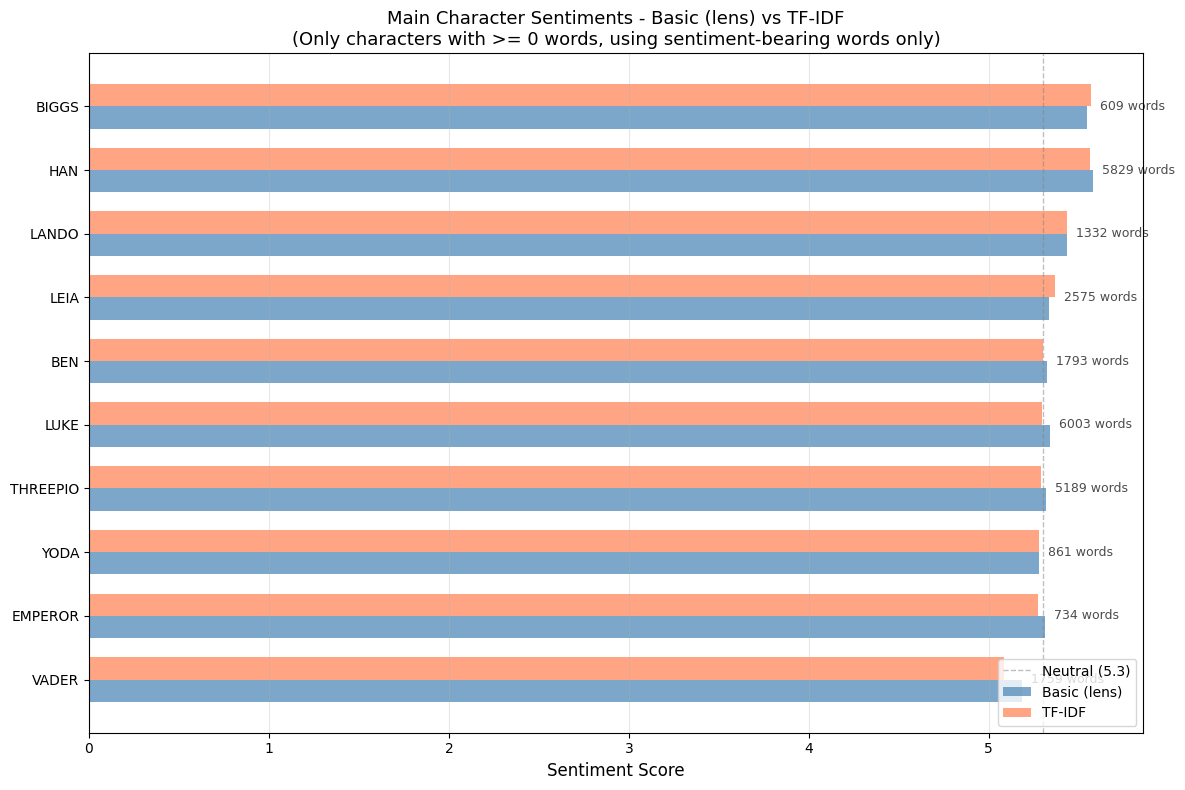


Main Character Sentiment Summary:
character  basic_lens    tfidf  words
    VADER    5.184508 5.084045   1759
  EMPEROR    5.313223 5.275765    734
     YODA    5.277829 5.277125    861
 THREEPIO    5.317296 5.288890   5189
     LUKE    5.340135 5.298083   6003
      BEN    5.323574 5.299003   1793
     LEIA    5.335033 5.366732   2575
    LANDO    5.433288 5.436859   1332
      HAN    5.579869 5.562522   5829
    BIGGS    5.543974 5.567523    609


In [19]:
# Focus on main characters (only those with sufficient dialogue)
main_characters = [
    'LUKE', 'HAN', 'LEIA', 'VADER', 'THREEPIO', 
    'YODA', 'BEN', 'EMPEROR', 'LANDO', 'BIGGS'
]

# Get data for main characters - using new data structures
main_char_data = []
for char in main_characters:
    basic_data = char_sentiments_lens.get(char, {})
    tfidf_data = tfidf_results.get(char, {})
    
    basic_sent = basic_data.get('sentiment')
    tfidf_sent = tfidf_data.get('sentiment')
    wc = basic_data.get('word_count', 0)
    
    # Only include if we have valid sentiment and sufficient words
    if basic_sent is not None and tfidf_sent is not None and wc >= MIN_WORDS_PRIMARY:
        main_char_data.append({
            'character': char,
            'basic_lens': basic_sent,
            'tfidf': tfidf_sent,
            'words': wc
        })

main_df = pd.DataFrame(main_char_data)
main_df = main_df.sort_values('tfidf', ascending=True)

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))

y_pos = np.arange(len(main_df))
width = 0.35

# Plot bars
bars1 = ax.barh(y_pos - width/2, main_df['basic_lens'], width, label='Basic (lens)', color='steelblue', alpha=0.7)
bars2 = ax.barh(y_pos + width/2, main_df['tfidf'], width, label='TF-IDF', color='coral', alpha=0.7)

# Add neutral line
ax.axvline(x=NEUTRAL, color='gray', linestyle='--', linewidth=1, alpha=0.5, label=f'Neutral ({NEUTRAL})')

ax.set_yticks(y_pos)
ax.set_yticklabels(main_df['character'])
ax.set_xlabel('Sentiment Score', fontsize=12)
ax.set_title(f'Main Character Sentiments - Basic (lens) vs TF-IDF\n(Only characters with >= {MIN_WORDS_PRIMARY} words, using sentiment-bearing words only)', fontsize=13)
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='x', alpha=0.3)

# Add word count annotations
for i, (_, row) in enumerate(main_df.iterrows()):
    max_val = max(row['basic_lens'], row['tfidf'])
    ax.text(max_val + 0.05, i, f"{row['words']} words", 
            va='center', fontsize=9, alpha=0.7)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "main_character_sentiments.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nMain Character Sentiment Summary:")
print(main_df.to_string(index=False))


## 8. Character-Specific Top Words Analysis

Let's examine which words have the highest TF-IDF weights for key characters, and their sentiment contribution.


In [20]:
def get_top_sentiment_words(character: str, n: int = 10, min_deviation: float = SENTIMENT_DELTA, 
                           use_stemming: bool = True) -> list:
    """
    Get top MEANINGFUL sentiment-contributing words for a character.
    
    Key improvements:
    - Excludes function words (pronouns, auxiliaries, etc.)
    - Only includes words with strong sentiment (|h-5| > min_deviation)
    - Sorts by absolute contribution to sentiment
    - Uses stemming to match more words (e.g., 'fighting' -> 'fight')
    
    Returns words that actually reveal character sentiment patterns.
    """
    char_list = list(character_dialogues.keys())
    if character not in char_list:
        return []
    
    char_idx = char_list.index(character)
    tfidf_weights = tfidf_matrix[char_idx].toarray().flatten()
    
    word_contributions = []
    for word_idx, weight in enumerate(tfidf_weights):
        if weight > 0:
            word = feature_names[word_idx]
            
            # Skip function words - they skew results!
            if word in STOP_WORDS:
                continue
            
            # Look up sentiment with optional stemming
            if use_stemming:
                happiness, matched_word = lookup_sentiment(word, word_to_happiness)
            else:
                happiness = word_to_happiness.get(word)
                matched_word = word if happiness else None
                
            if happiness is not None:
                deviation = happiness - NEUTRAL
                
                # Only include sentiment-bearing words (far from neutral)
                if abs(deviation) > min_deviation:
                    contribution = weight * deviation
                    word_contributions.append({
                        'word': word,
                        'matched': matched_word if matched_word != word else None,  # Show stem if different
                        'tfidf': weight,
                        'happiness': happiness,
                        'deviation': deviation,
                        'contribution': contribution
                    })
    
    # Sort by absolute contribution (most impactful words)
    word_contributions.sort(key=lambda x: abs(x['contribution']), reverse=True)
    return word_contributions[:n]


# Analyze key characters (only those with sufficient dialogue)
key_characters = ['LUKE', 'VADER', 'YODA', 'HAN', 'LEIA', 'THREEPIO', 'BEN', 'LANDO', 'EMPEROR']

print("="*70)
print("TOP SENTIMENT-CONTRIBUTING WORDS BY CHARACTER")
print("(Excluding function words, only sentiment-bearing words |h-5| > 1.0)")
print("="*70)

for char in key_characters:
    wc = word_counts.get(char, 0)
    if wc < MIN_WORDS_PRIMARY:
        continue
        
    top_words = get_top_sentiment_words(char, n=8)
    if top_words:
        sentiment = tfidf_results.get(char, {}).get('sentiment', 0)
        print(f"\n{char} (sentiment: {sentiment:.3f}, {wc} words):")
        
        # Separate positive and negative contributors
        positive_words = [w for w in top_words if w['contribution'] > 0]
        negative_words = [w for w in top_words if w['contribution'] < 0]
        
        if positive_words:
            print(f"  ↑ Positive contributors:")
            for w in positive_words[:4]:
                print(f"      '{w['word']}': h={w['happiness']:.1f}, contrib={w['contribution']:+.3f}")
        
        if negative_words:
            print(f"  ↓ Negative contributors:")
            for w in negative_words[:4]:
                print(f"      '{w['word']}': h={w['happiness']:.1f}, contrib={w['contribution']:+.3f}")


TOP SENTIMENT-CONTRIBUTING WORDS BY CHARACTER
(Excluding function words, only sentiment-bearing words |h-5| > 1.0)

LUKE (sentiment: 5.298, 6003 words):
  ↑ Positive contributors:
      'father': h=7.1, contrib=+0.241
      'right': h=6.5, contrib=+0.215
      'well': h=6.7, contrib=+0.189
      'friend': h=7.7, contrib=+0.154
  ↓ Negative contributors:
      'can't': h=3.4, contrib=-0.263
      'die': h=1.7, contrib=-0.152

VADER (sentiment: 5.084, 1759 words):
  ↑ Positive contributors:
      'good': h=7.2, contrib=+0.162
      'captain': h=6.6, contrib=+0.151
      'alive': h=7.2, contrib=+0.137
  ↓ Negative contributors:
      'destroy': h=2.5, contrib=-0.324
      'dark': h=3.8, contrib=-0.235
      'betray': h=2.5, contrib=-0.152
      'damaged': h=2.5, contrib=-0.144

YODA (sentiment: 5.277, 861 words):
  ↑ Positive contributors:
      'yes': h=6.7, contrib=+0.325
      'strong': h=7.1, contrib=+0.274
      'sky': h=7.8, contrib=+0.198
      'rest': h=7.2, contrib=+0.181
  ↓ Neg

## 10. Save Results


In [21]:
# =============================================================================
# SAVE RESULTS
# =============================================================================

# 1. Save LOCATION sentiments (primary)
loc_output = {}
for loc, data in location_sentiments.items():
    loc_output[loc] = {
        'sentiment': data['sentiment'],
        'word_count': data['word_count'],
        'scored_words': data['scored_words'],
        'quality': data['quality']
    }

loc_json_path = DATA_DIR / "location_sentiments.json"
with open(loc_json_path, 'w', encoding='utf-8') as f:
    json.dump(loc_output, f, indent=2)
print(f"Saved location sentiments to {loc_json_path}")

# Save location CSV
loc_csv_data = [
    {'location': loc, 'sentiment': d['sentiment'], 'word_count': d['word_count'], 'quality': d['quality']}
    for loc, d in location_sentiments.items() if d['sentiment'] is not None
]
loc_df = pd.DataFrame(loc_csv_data).sort_values('sentiment', ascending=False, na_position='last')
loc_csv_path = DATA_DIR / "location_sentiments.csv"
loc_df.to_csv(loc_csv_path, index=False)
print(f"Saved location sentiments to {loc_csv_path}")

# 2. Save CHARACTER sentiments
char_output = {}
for char, data in character_sentiments.items():
    char_output[char] = {
        'sentiment': data['sentiment'],
        'word_count': data['word_count'],
        'scored_words': data['scored_words'],
        'quality': data['quality'],
        'line_count': len(character_dialogues.get(char, []))
    }

char_json_path = DATA_DIR / "character_sentiments.json"
with open(char_json_path, 'w', encoding='utf-8') as f:
    json.dump(char_output, f, indent=2)
print(f"Saved character sentiments to {char_json_path}")

# Save character CSV
char_csv_data = [
    {'character': char, 'sentiment': d['sentiment'], 'word_count': d['word_count'], 
     'line_count': len(character_dialogues.get(char, [])), 'quality': d['quality']}
    for char, d in character_sentiments.items() if d['sentiment'] is not None
]
char_df = pd.DataFrame(char_csv_data).sort_values('sentiment', ascending=False, na_position='last')
char_csv_path = DATA_DIR / "character_sentiments.csv"
char_df.to_csv(char_csv_path, index=False)
print(f"Saved character sentiments to {char_csv_path}")

# Display summaries
print(f"\n{'='*70}")
print("SUMMARY OF SAVED DATA")
print(f"{'='*70}")
print(f"\nLocations: {len(loc_output)} total, {len([l for l in loc_output.values() if l['quality'] in ['high', 'medium']])} with sufficient data")
print(f"Characters: {len(char_output)} total, {len([c for c in char_output.values() if c['quality'] == 'high'])} with high quality data")


Saved location sentiments to ../data/location_sentiments.json
Saved location sentiments to ../data/location_sentiments.csv
Saved character sentiments to ../data/character_sentiments.json
Saved character sentiments to ../data/character_sentiments.csv

SUMMARY OF SAVED DATA

Locations: 456 total, 456 with sufficient data
Characters: 137 total, 137 with high quality data


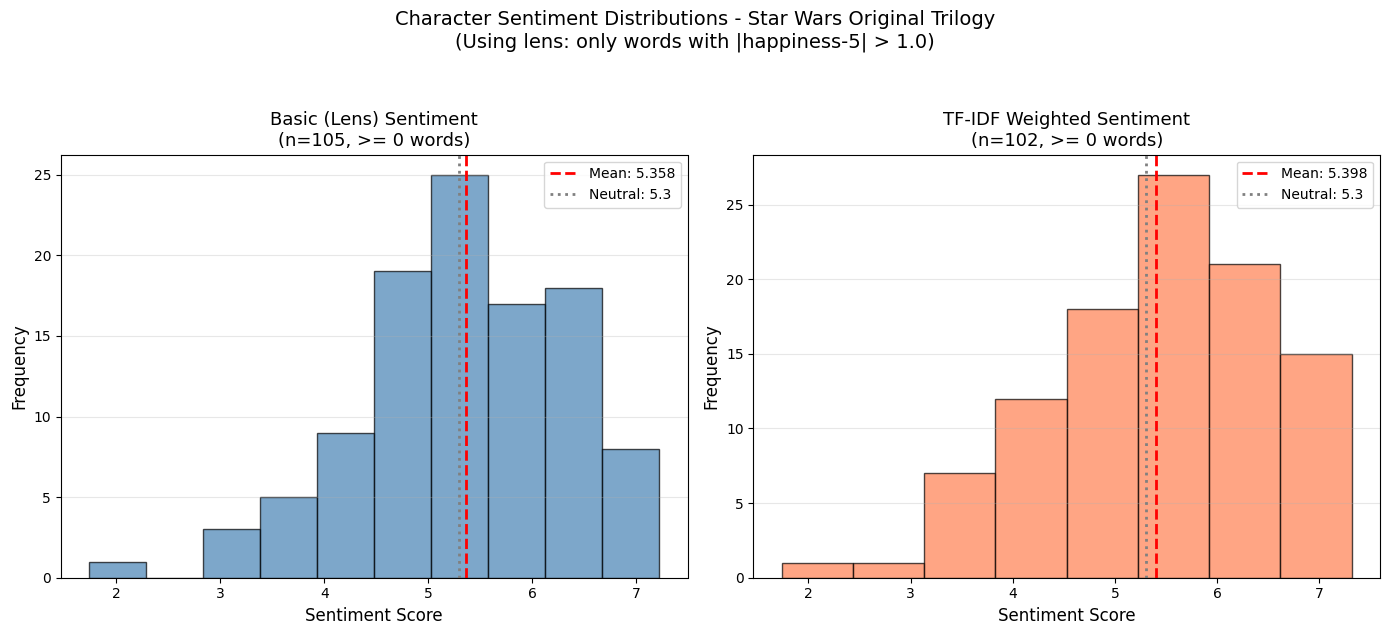


Note: Only showing 105 characters with >= 0 words


In [22]:
# Plot distributions side by side (only high-quality characters)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Filter to primary quality characters
basic_scores = [
    v['sentiment'] for v in char_sentiments_lens.values() 
    if v['sentiment'] is not None and v['word_count'] >= MIN_WORDS_PRIMARY
]
tfidf_scores_list = [
    v['sentiment'] for v in tfidf_results.values()
    if v['sentiment'] is not None and v['word_count'] >= MIN_WORDS_PRIMARY
]

# Basic (lens) sentiment distribution
ax = axes[0]
ax.hist(basic_scores, bins='auto', color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(np.mean(basic_scores), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(basic_scores):.3f}')
ax.axvline(NEUTRAL, color='gray', linestyle=':', linewidth=2, label=f'Neutral: {NEUTRAL}')
ax.set_xlabel('Sentiment Score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title(f'Basic (Lens) Sentiment\n(n={len(basic_scores)}, >= {MIN_WORDS_PRIMARY} words)', fontsize=13)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

# TF-IDF sentiment distribution
ax = axes[1]
ax.hist(tfidf_scores_list, bins='auto', color='coral', edgecolor='black', alpha=0.7)
ax.axvline(np.mean(tfidf_scores_list), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {np.mean(tfidf_scores_list):.3f}')
ax.axvline(NEUTRAL, color='gray', linestyle=':', linewidth=2, label=f'Neutral: {NEUTRAL}')
ax.set_xlabel('Sentiment Score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title(f'TF-IDF Weighted Sentiment\n(n={len(tfidf_scores_list)}, >= {MIN_WORDS_PRIMARY} words)', fontsize=13)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.suptitle('Character Sentiment Distributions - Star Wars Original Trilogy\n(Using lens: only words with |happiness-5| > 1.0)', 
             fontsize=14, y=1.05)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "sentiment_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nNote: Only showing {len(basic_scores)} characters with >= {MIN_WORDS_PRIMARY} words")


## 11. TF-IDF Word Clouds by Character Type

Let's visualize the distinctive vocabulary of different character types using word clouds weighted by TF-IDF scores. This helps us understand what language patterns define:

1. **Jedi Characters** (Luke, Yoda, Ben/Obi-Wan) - Do they speak neutrally about the Force?
2. **Sith/Empire Characters** (Darth Vader, Emperor) - What themes dominate their dialogue?


In [23]:
# Install wordcloud if needed
try:
    from wordcloud import WordCloud
    print("WordCloud library loaded successfully!")
except ImportError:
    print("Installing wordcloud...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'wordcloud'])
    from wordcloud import WordCloud
    print("WordCloud installed and loaded!")

# Define character groups
# Define character groups
CHARACTER_GROUPS = {
    'Jedi': ['LUKE', 'LUKE SKYWALKER', 'YODA', 'BEN', 'OBI-WAN', 'OBIWAN', 'OBI-WAN KENOBI'],
    'Sith/Empire': ['VADER', 'DARTH VADER', 'LORD VADER', 'EMPEROR', 'EMPEROR PALPATINE', 'PALPATINE', 'TARKIN', 'GRAND MOFF TARKIN'],
    'Rebels/Heroes': ['HAN', 'HAN SOLO', 'LEIA', 'LEIA ORGANA', 'PRINCESS LEIA', 'LANDO', 'LANDO CALRISSIAN', 
                      'CHEWBACCA', 'CHEWIE', 'WEDGE', 'WEDGE ANTILLES', 'BIGGS', 'BIGGS DARKLIGHTER', 
                      'ACKBAR', 'RIEEKAN', 'DODONNA'],
    'Droids': ['THREEPIO', 'C-3PO', 'C3PO', 'THREE-PO', 'ARTOO', 'R2-D2', 'R2D2', 'ARTOO-DETOO']
}

# Color schemes for word clouds
GROUP_COLORS = {
    'Jedi': 'Blues',
    'Sith/Empire': 'Reds',
    'Rebels/Heroes': 'Greens',
    'Droids': 'copper'
}

print("\nCharacter Groups defined:")
for group, chars in CHARACTER_GROUPS.items():
    group_words = sum(word_counts.get(c, 0) for c in chars)
    print(f"  {group}: {chars} ({group_words} total words)")


WordCloud library loaded successfully!

Character Groups defined:
  Jedi: ['LUKE', 'LUKE SKYWALKER', 'YODA', 'BEN', 'OBI-WAN', 'OBIWAN', 'OBI-WAN KENOBI'] (8657 total words)
  Sith/Empire: ['VADER', 'DARTH VADER', 'LORD VADER', 'EMPEROR', 'EMPEROR PALPATINE', 'PALPATINE', 'TARKIN', 'GRAND MOFF TARKIN'] (2884 total words)
  Rebels/Heroes: ['HAN', 'HAN SOLO', 'LEIA', 'LEIA ORGANA', 'PRINCESS LEIA', 'LANDO', 'LANDO CALRISSIAN', 'CHEWBACCA', 'CHEWIE', 'WEDGE', 'WEDGE ANTILLES', 'BIGGS', 'BIGGS DARKLIGHTER', 'ACKBAR', 'RIEEKAN', 'DODONNA'] (11054 total words)
  Droids: ['THREEPIO', 'C-3PO', 'C3PO', 'THREE-PO', 'ARTOO', 'R2-D2', 'R2D2', 'ARTOO-DETOO'] (5189 total words)


In [24]:
def get_group_tfidf_words(group_characters: list, top_n: int = 100) -> dict:
    """
    Get TF-IDF weighted word frequencies for a group of characters.
    Aggregates TF-IDF scores across all characters in the group.
    
    Returns dict: word -> aggregated TF-IDF weight
    """
    char_list = list(character_dialogues.keys())
    aggregated_weights = Counter()
    
    for char in group_characters:
        if char not in char_list:
            continue
        
        char_idx = char_list.index(char)
        tfidf_weights = tfidf_matrix[char_idx].toarray().flatten()
        
        for word_idx, weight in enumerate(tfidf_weights):
            if weight > 0:
                word = feature_names[word_idx]
                # Skip stopwords
                if word not in STOP_WORDS:
                    aggregated_weights[word] += weight
    
    # Return top N words
    return dict(aggregated_weights.most_common(top_n))


def get_sentiment_colored_frequencies(word_freq: dict, use_sentiment: bool = True) -> dict:
    """
    Get word frequencies, optionally colored by sentiment.
    For word cloud display, we just return the frequencies.
    """
    return word_freq


# Compute TF-IDF words for each group
group_words = {}
for group, chars in CHARACTER_GROUPS.items():
    group_words[group] = get_group_tfidf_words(chars, top_n=150)
    print(f"\n{group} - Top 20 TF-IDF words:")
    top_20 = list(group_words[group].items())[:20]
    for word, weight in top_20:
        # Use stemming-aware lookup
        sentiment, _ = lookup_sentiment(word, word_to_happiness)
        sentiment = sentiment if sentiment is not None else NEUTRAL
        sent_label = "+" if sentiment > 5.5 else "-" if sentiment < 4.5 else "~"
        print(f"  {word}: {weight:.3f} (h={sentiment:.1f} {sent_label})")



Jedi - Top 20 TF-IDF words:
  luke: 0.911 (h=5.3 ~)
  force: 0.670 (h=4.0 -)
  must: 0.441 (h=4.8 ~)
  father: 0.415 (h=7.1 +)
  artoo: 0.412 (h=5.3 ~)
  jedi: 0.388 (h=5.3 ~)
  ben: 0.375 (h=5.1 ~)
  yes: 0.297 (h=6.7 +)
  know: 0.295 (h=6.1 +)
  side: 0.292 (h=5.1 ~)
  well: 0.291 (h=6.7 +)
  yoda: 0.265 (h=5.3 ~)
  go: 0.261 (h=5.5 +)
  see: 0.248 (h=6.1 +)
  strong: 0.239 (h=7.1 +)
  dark: 0.230 (h=3.8 -)
  back: 0.228 (h=5.2 ~)
  threepio: 0.228 (h=5.3 ~)
  come: 0.228 (h=5.8 +)
  mind: 0.221 (h=6.0 +)

Sith/Empire - Top 20 TF-IDF words:
  vader: 0.523 (h=5.3 ~)
  emperor: 0.443 (h=5.3 ~)
  yes: 0.384 (h=6.7 +)
  rebel: 0.378 (h=4.4 -)
  us: 0.344 (h=6.3 +)
  dark: 0.343 (h=3.8 -)
  side: 0.337 (h=5.1 ~)
  would: 0.318 (h=5.4 ~)
  must: 0.313 (h=4.8 ~)
  skywalker: 0.301 (h=5.3 ~)
  friends: 0.292 (h=7.9 +)
  young: 0.290 (h=6.8 +)
  obi: 0.280 (h=5.3 ~)
  wan: 0.280 (h=5.3 ~)
  luke: 0.270 (h=5.3 ~)
  power: 0.268 (h=6.7 +)
  perhaps: 0.251 (h=5.0 ~)
  ship: 0.241 (h=6.0 +)
  st

In [25]:
# Analyze sentiment breakdown of top words for each group
def analyze_group_word_sentiment(group_name: str, word_freq: dict) -> dict:
    """
    Analyze the sentiment distribution of top words for a character group.
    Uses stemming to match more words to sentiment scores.
    """
    positive_words = []  # h > 6.0
    negative_words = []  # h < 4.0
    neutral_words = []   # 4.0 <= h <= 6.0
    
    total_weight = 0
    weighted_sentiment = 0
    
    for word, weight in word_freq.items():
        # Use stemming-aware lookup
        sentiment, _ = lookup_sentiment(word, word_to_happiness)
        sentiment = sentiment if sentiment is not None else NEUTRAL
        total_weight += weight
        weighted_sentiment += weight * sentiment
        
        if sentiment > 6.0:
            positive_words.append((word, weight, sentiment))
        elif sentiment < 4.0:
            negative_words.append((word, weight, sentiment))
        else:
            neutral_words.append((word, weight, sentiment))
    
    # Sort by weight
    positive_words.sort(key=lambda x: x[1], reverse=True)
    negative_words.sort(key=lambda x: x[1], reverse=True)
    neutral_words.sort(key=lambda x: x[1], reverse=True)
    
    avg_sentiment = weighted_sentiment / total_weight if total_weight > 0 else NEUTRAL
    
    return {
        'avg_sentiment': avg_sentiment,
        'positive': positive_words,
        'negative': negative_words,
        'neutral': neutral_words,
        'pct_positive': len(positive_words) / len(word_freq) * 100,
        'pct_negative': len(negative_words) / len(word_freq) * 100,
        'pct_neutral': len(neutral_words) / len(word_freq) * 100,
    }


# Analyze both groups
print("=" * 70)
print("SENTIMENT ANALYSIS OF TOP TF-IDF WORDS")
print("=" * 70)

for group in ['Jedi', 'Sith/Empire']:
    analysis = analyze_group_word_sentiment(group, group_words[group])
    
    print(f"\n{'='*40}")
    print(f"📊 {group.upper()}")
    print(f"{'='*40}")
    print(f"\nWeighted Average Sentiment: {analysis['avg_sentiment']:.3f}")
    print(f"  (Neutral = 5.0)")
    print(f"\nWord Distribution:")
    print(f"  Positive (h > 6.0): {analysis['pct_positive']:.1f}% ({len(analysis['positive'])} words)")
    print(f"  Neutral (4-6): {analysis['pct_neutral']:.1f}% ({len(analysis['neutral'])} words)")
    print(f"  Negative (h < 4.0): {analysis['pct_negative']:.1f}% ({len(analysis['negative'])} words)")
    
    print(f"\n🌟 Top 8 POSITIVE words:")
    for word, weight, sent in analysis['positive'][:8]:
        print(f"    '{word}': TF-IDF={weight:.3f}, h={sent:.1f}")
    
    print(f"\n⚡ Top 8 NEGATIVE words:")
    for word, weight, sent in analysis['negative'][:8]:
        print(f"    '{word}': TF-IDF={weight:.3f}, h={sent:.1f}")


SENTIMENT ANALYSIS OF TOP TF-IDF WORDS

📊 JEDI

Weighted Average Sentiment: 5.444
  (Neutral = 5.0)

Word Distribution:
  Positive (h > 6.0): 29.3% (44 words)
  Neutral (4-6): 58.7% (88 words)
  Negative (h < 4.0): 12.0% (18 words)

🌟 Top 8 POSITIVE words:
    'father': TF-IDF=0.415, h=7.1
    'yes': TF-IDF=0.297, h=6.7
    'know': TF-IDF=0.295, h=6.1
    'well': TF-IDF=0.291, h=6.7
    'see': TF-IDF=0.248, h=6.1
    'strong': TF-IDF=0.239, h=7.1
    'mind': TF-IDF=0.221, h=6.0
    'like': TF-IDF=0.213, h=7.2

⚡ Top 8 NEGATIVE words:
    'dark': TF-IDF=0.230, h=3.8
    'old': TF-IDF=0.197, h=4.0
    'can't': TF-IDF=0.196, h=3.4
    'never': TF-IDF=0.144, h=3.3
    'cannot': TF-IDF=0.130, h=3.3
    'evil': TF-IDF=0.123, h=1.9
    'anger': TF-IDF=0.119, h=2.3
    'fear': TF-IDF=0.112, h=2.3

📊 SITH/EMPIRE

Weighted Average Sentiment: 5.471
  (Neutral = 5.0)

Word Distribution:
  Positive (h > 6.0): 30.0% (45 words)
  Neutral (4-6): 58.7% (88 words)
  Negative (h < 4.0): 11.3% (17 words)


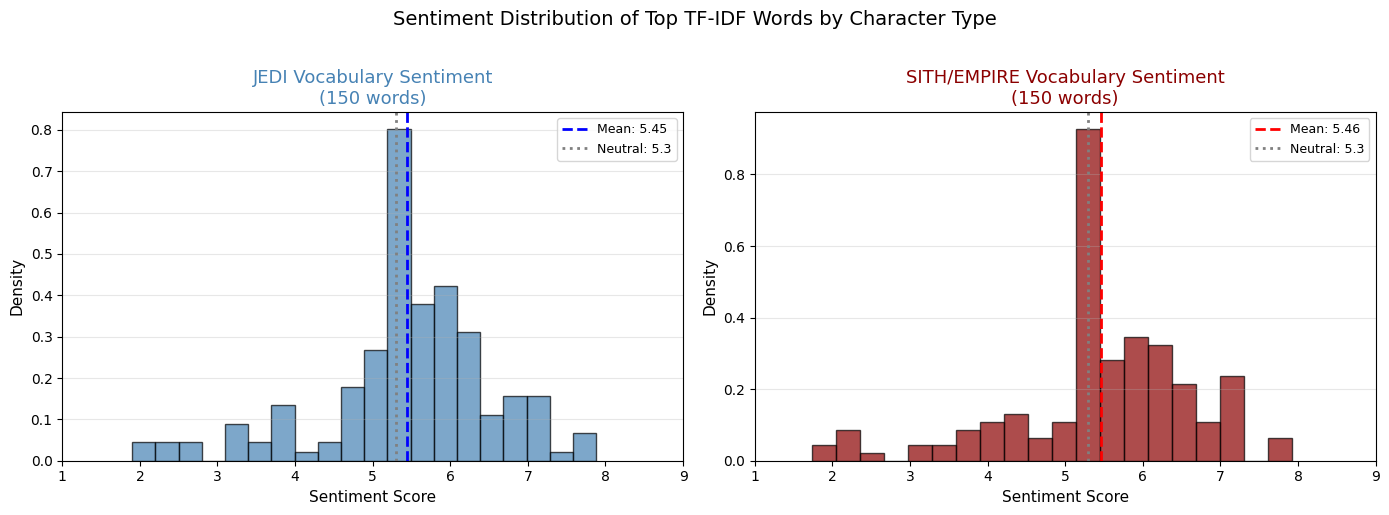


📊 Statistical Comparison:

  JEDI vocabulary:
    Mean sentiment: 5.447
    Std deviation: 1.114
    Min: 1.90, Max: 7.88

  SITH/EMPIRE vocabulary:
    Mean sentiment: 5.459
    Std deviation: 1.188
    Min: 1.74, Max: 7.92

  Difference: -0.012
  (Jedi vocabulary is more negative on average)


In [26]:
# Compare sentiment distributions of words used by each group
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Get sentiment scores for top words in each group (using stemming)
def get_sentiment_list(words):
    sentiments = []
    for w in words:
        s, _ = lookup_sentiment(w, word_to_happiness)
        sentiments.append(s if s is not None else NEUTRAL)
    return sentiments

jedi_sentiments = get_sentiment_list(group_words['Jedi'].keys())
sith_sentiments = get_sentiment_list(group_words['Sith/Empire'].keys())

# Jedi histogram
ax = axes[0]
ax.hist(jedi_sentiments, bins=20, color='steelblue', edgecolor='black', alpha=0.7, density=True)
ax.axvline(np.mean(jedi_sentiments), color='blue', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(jedi_sentiments):.2f}')
ax.axvline(NEUTRAL, color='gray', linestyle=':', linewidth=2, label=f'Neutral: {NEUTRAL}')
ax.set_xlabel('Sentiment Score', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title(f'JEDI Vocabulary Sentiment\n({len(jedi_sentiments)} words)', fontsize=13, color='steelblue')
ax.legend(fontsize=9)
ax.set_xlim(1, 9)
ax.grid(axis='y', alpha=0.3)

# Sith histogram
ax = axes[1]
ax.hist(sith_sentiments, bins=20, color='darkred', edgecolor='black', alpha=0.7, density=True)
ax.axvline(np.mean(sith_sentiments), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(sith_sentiments):.2f}')
ax.axvline(NEUTRAL, color='gray', linestyle=':', linewidth=2, label=f'Neutral: {NEUTRAL}')
ax.set_xlabel('Sentiment Score', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title(f'SITH/EMPIRE Vocabulary Sentiment\n({len(sith_sentiments)} words)', fontsize=13, color='darkred')
ax.legend(fontsize=9)
ax.set_xlim(1, 9)
ax.grid(axis='y', alpha=0.3)

plt.suptitle('Sentiment Distribution of Top TF-IDF Words by Character Type', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "wordcloud_sentiment_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# Statistical comparison
print("\n📊 Statistical Comparison:")
print(f"\n  JEDI vocabulary:")
print(f"    Mean sentiment: {np.mean(jedi_sentiments):.3f}")
print(f"    Std deviation: {np.std(jedi_sentiments):.3f}")
print(f"    Min: {min(jedi_sentiments):.2f}, Max: {max(jedi_sentiments):.2f}")

print(f"\n  SITH/EMPIRE vocabulary:")
print(f"    Mean sentiment: {np.mean(sith_sentiments):.3f}")
print(f"    Std deviation: {np.std(sith_sentiments):.3f}")
print(f"    Min: {min(sith_sentiments):.2f}, Max: {max(sith_sentiments):.2f}")

print(f"\n  Difference: {np.mean(jedi_sentiments) - np.mean(sith_sentiments):.3f}")
print(f"  (Jedi vocabulary is {'more positive' if np.mean(jedi_sentiments) > np.mean(sith_sentiments) else 'more negative'} on average)")


Computing sentiment ranges for each group...
  Jedi: min=1.90, max=7.88
  Sith/Empire: min=1.74, max=7.92
  Rebels/Heroes: min=1.54, max=7.66
  Droids: min=1.74, max=7.72


/var/folders/vs/4fkzxbz13mj7pqtlqnh916m00000gn/T/ipykernel_21767/736169502.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap(colormap_name)


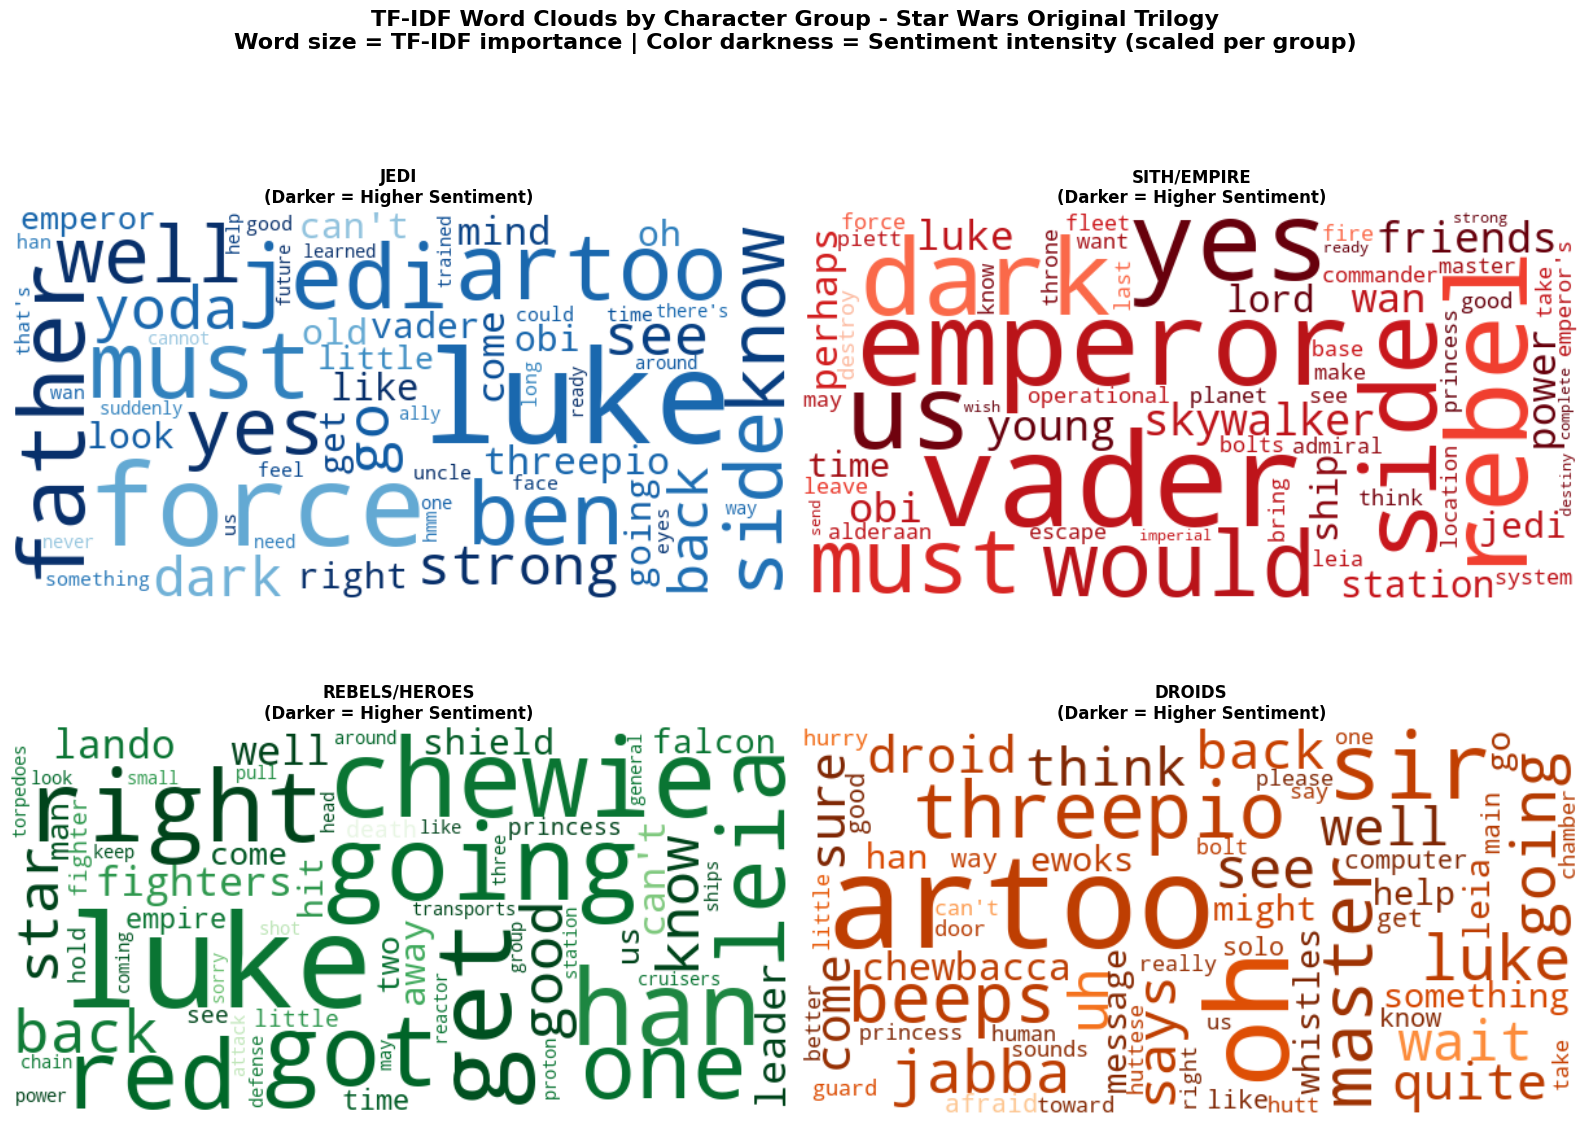


📊 Sentiment-colored word clouds saved to figures/wordcloud_all_groups_sentiment.png


In [27]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

# Define colormap for each group
GROUP_COLORMAPS = {
    'Jedi': 'Blues',
    'Sith/Empire': 'Reds',
    'Rebels/Heroes': 'Greens',
    'Droids': 'Oranges',
}

def compute_group_sentiment_range(group_name: str, word_freq: dict):
    """
    Compute min and max sentiment values for a group's words.
    Returns (min_sentiment, max_sentiment)
    """
    sentiments = []
    for word in word_freq.keys():
        sentiment, _ = lookup_sentiment(word.lower(), word_to_happiness)
        if sentiment is not None:
            sentiments.append(sentiment)
    
    if sentiments:
        return min(sentiments), max(sentiments)
    else:
        return NEUTRAL, NEUTRAL

def create_sentiment_colormap_func(group_name: str, min_sentiment: float, max_sentiment: float):
    """
    Create a color function that uses the group's colormap with intensity based on sentiment.
    Min sentiment = very light color, Max sentiment = dark color.
    """
    colormap_name = GROUP_COLORMAPS[group_name]
    colormap = cm.get_cmap(colormap_name)
    
    def sentiment_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        # Use stemming-aware lookup
        sentiment, _ = lookup_sentiment(word.lower(), word_to_happiness)
        if sentiment is None:
            sentiment = NEUTRAL
        
        # Scale sentiment to 0-1 range based on group's min/max
        # 0.0 = min_sentiment (very light), 1.0 = max_sentiment (dark)
        if max_sentiment > min_sentiment:
            normalized = (sentiment - min_sentiment) / (max_sentiment - min_sentiment)
        else:
            normalized = 0.5  # If all same, use middle
        
        # Clamp to [0, 1]
        normalized = max(0.0, min(1.0, normalized))
        
        # Map to colormap with wider range for better contrast
        # 0.0 = very light (0.1), 1.0 = very dark (1.0)
        # This creates a range from 0.1 to 1.0 for maximum contrast
        colormap_value = 0.1 + (normalized * 1.2)  # Range from 0.1 to 1.0
        
        # Get color from colormap (returns RGBA, convert to RGB)
        rgba = colormap(colormap_value)
        r, g, b = int(rgba[0] * 255), int(rgba[1] * 255), int(rgba[2] * 255)
        
        return f"rgb({r}, {g}, {b})"
    
    return sentiment_color_func


# Word cloud parameters
wc_params = {
    'width': 600,
    'height': 300,
    'background_color': 'white',
    'max_words': 60,
    'prefer_horizontal': 0.7,
    'min_font_size': 8,
    'max_font_size': 100,
    'relative_scaling': 0.5,
}

# First, compute sentiment ranges for each group
print("Computing sentiment ranges for each group...")
group_ranges = {}
for group_name in CHARACTER_GROUPS.keys():
    if group_name in group_words:
        min_sent, max_sent = compute_group_sentiment_range(group_name, group_words[group_name])
        group_ranges[group_name] = (min_sent, max_sent)
        print(f"  {group_name}: min={min_sent:.2f}, max={max_sent:.2f}")

# Create 2x2 grid for all 4 character groups
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Panel configs: (group_name, row, col)
panels = [
    ('Jedi', 0, 0),
    ('Sith/Empire', 0, 1),
    ('Rebels/Heroes', 1, 0),
    ('Droids', 1, 1),
]

for group_name, row, col in panels:
    ax = axes[row, col]
    
    # Get sentiment range for this group
    min_sent, max_sent = group_ranges.get(group_name, (NEUTRAL, NEUTRAL))
    
    # Create group-specific color function with sentiment-based intensity
    color_func = create_sentiment_colormap_func(group_name, min_sent, max_sent)
    
    # Generate word cloud
    wc = WordCloud(**wc_params).generate_from_frequencies(group_words[group_name])
    wc.recolor(color_func=color_func)
    
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f'{group_name.upper()}\n(Darker = Higher Sentiment)', 
                 fontsize=12, fontweight='bold')
    ax.axis('off')

plt.suptitle('TF-IDF Word Clouds by Character Group - Star Wars Original Trilogy\n' +
             'Word size = TF-IDF importance | Color darkness = Sentiment intensity (scaled per group)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "wordcloud_all_groups_sentiment.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Sentiment-colored word clouds saved to figures/wordcloud_all_groups_sentiment.png")

In [28]:
# Final summary: Print character group sentiments
print("=" * 70)
print("FINAL SUMMARY: Character Group Sentiments")
print("=" * 70)

for group, chars in CHARACTER_GROUPS.items():
    # Calculate average sentiment for each group
    group_sentiment = []
    for char in chars:
        sent = tfidf_results.get(char, {}).get('sentiment')
        if sent is not None:
            group_sentiment.append(sent)
    
    if group_sentiment:
        avg_sent = np.mean(group_sentiment)
        total_words = sum(word_counts.get(c, 0) for c in chars)
        
        # Sentiment interpretation
        if avg_sent > 5.7:
            interpretation = "Positive 🌟"
        elif avg_sent < 5.3:
            interpretation = "Darker ⚡"
        else:
            interpretation = "Neutral/Balanced 🧘"
            
        print(f"\n{group}:")
        print(f"  Characters: {', '.join(chars)}")
        print(f"  Average Sentiment: {avg_sent:.3f} ({interpretation})")
        print(f"  Total Words: {total_words:,}")


FINAL SUMMARY: Character Group Sentiments

Jedi:
  Characters: LUKE, LUKE SKYWALKER, YODA, BEN, OBI-WAN, OBIWAN, OBI-WAN KENOBI
  Average Sentiment: 5.291 (Darker ⚡)
  Total Words: 8,657

Sith/Empire:
  Characters: VADER, DARTH VADER, LORD VADER, EMPEROR, EMPEROR PALPATINE, PALPATINE, TARKIN, GRAND MOFF TARKIN
  Average Sentiment: 5.317 (Neutral/Balanced 🧘)
  Total Words: 2,884

Rebels/Heroes:
  Characters: HAN, HAN SOLO, LEIA, LEIA ORGANA, PRINCESS LEIA, LANDO, LANDO CALRISSIAN, CHEWBACCA, CHEWIE, WEDGE, WEDGE ANTILLES, BIGGS, BIGGS DARKLIGHTER, ACKBAR, RIEEKAN, DODONNA
  Average Sentiment: 5.300 (Darker ⚡)
  Total Words: 11,054

Droids:
  Characters: THREEPIO, C-3PO, C3PO, THREE-PO, ARTOO, R2-D2, R2D2, ARTOO-DETOO
  Average Sentiment: 5.289 (Darker ⚡)
  Total Words: 5,189
